# Ensembles of Predictors
================
Ensemble methods
================



The goal of **ensemble methods** is to combine the predictions of several
base estimators built with a given learning algorithm in order to improve
generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

- In **averaging methods**, the driving principle is to build several
  estimators independently and then to average their predictions. On average,
  the combined estimator is usually better than any of the single base
  estimator because its variance is reduced.

  **Examples:** `Bagging methods`, `Forests of randomized trees `, ...

- By contrast, in **boosting methods**, base estimators are built sequentially
  and one tries to reduce the bias of the combined estimator. The motivation is
  to combine several weak models to produce a powerful ensemble.

  **Examples:** `AdaBoost`, `Gradient Tree Boosting`, ...



## Gradient Tree Boosting

Boosting is the idea of making sequential models (called weak learers) that focus on the areas where previous learners had trouble getting the correct answer. 

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.  Until the mid 2010s this was being used at leading search engines.

The module sklearn.ensemble provides methods for both classification and regression via gradient boosted decision trees.


## Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please use the much faster
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

## Data preprocessing

Next, we will split our dataset to use 90% for training and leave the rest
for testing. We will also set the regression model parameters. You can play
with these parameters to see how the results change.

n_estimators : the number of boosting stages that will be performed.
Later, we will plot deviance against boosting iterations.

max_depth : limits the number of nodes in the tree.
The best value depends on the interaction of the input variables.

min_samples_split : the minimum number of samples required to split an
internal node.

learning_rate : how much the contribution of each tree will shrink.

loss : loss function to optimize. The least squares function is  used in this
case however, there are many other options (see
`~sklearn.ensemble.GradientBoostingRegressor` ).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [8]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3038.8717


## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



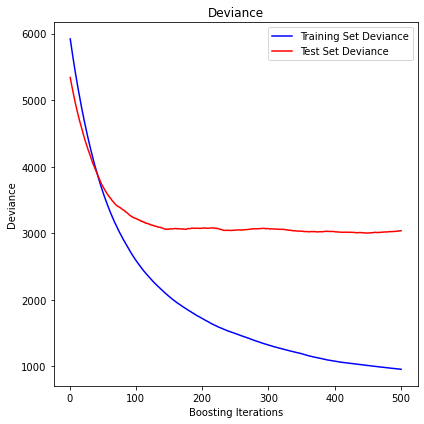

In [9]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Plot feature importance

Careful, impurity-based feature importances can be misleading for
high cardinality features (many unique values). As an alternative,
the permutation importances of ``reg`` can be computed on a
held out test set. See `permutation_importance` for more details.

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



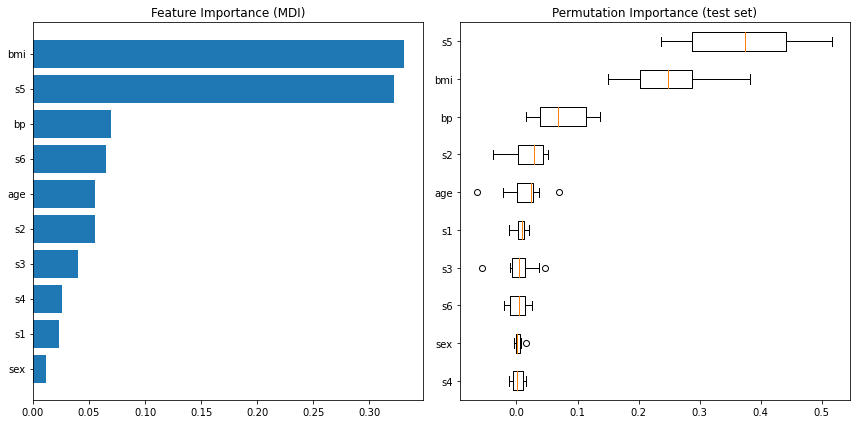

In [10]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(diabetes.feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()